In [33]:
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.pipeline import Pipeline as SKPipeline

from sklearn.svm import SVC
from itertools import combinations

from sklearn.preprocessing import StandardScaler, OneHotEncoder
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.compose import ColumnTransformer

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report,  make_scorer, fbeta_score, roc_curve, roc_auc_score
from scipy.stats import mode

from sklearn.ensemble import RandomForestClassifier



In [2]:
stroke = pd.read_csv("../00-data/healthcare-dataset-stroke-data.csv")

stroke


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


Splitto variabili indipendenti ed output

In [3]:
X = stroke.drop(['stroke', 'id'], axis=1)

y = stroke['stroke'].values

creo una funzione per fare oneHotEncoding e imputazione

In [4]:
numerical_features = X.select_dtypes(include=np.number).columns
categorical_features = X.select_dtypes(include='object').columns

numerical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='mean')),
  ('scaler', StandardScaler())
])

categorical_transformer = SKPipeline(steps=[
  ('imputer', SimpleImputer(strategy='most_frequent')),
  ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor_with_imputation = ColumnTransformer(
  transformers=[
    ('num', numerical_transformer, numerical_features),
    ('cat', categorical_transformer, categorical_features)
  ])


pipeline = ImbPipeline([
  ('preprocessor', preprocessor_with_imputation),
  ('undersampler', RandomUnderSampler(random_state=0, sampling_strategy=0.15)),
  ('oversampler', ADASYN(n_neighbors=7, random_state=0, sampling_strategy=1.0)),
  ('pca', PCA(random_state=0)),
])

calcolo train test split

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3, random_state=0)

pipeline.fit_transform(X_train)

In [6]:
X_train_pca = pipeline.fit_transform(X_train, y_train)

X_test_pca = pipeline.transform(X_test)

In [7]:
X_train_pca

array([[-6.67231769e-01,  1.29119021e-02,  4.57774225e-01, ...,
         2.08166817e-16, -5.10008702e-16,  8.88178420e-16],
       [-6.05073149e-01, -1.66698744e-02, -3.54374585e-01, ...,
        -1.24900090e-16, -2.87964097e-16, -1.66533454e-15],
       [-8.67175490e-01, -1.67627405e-01,  3.03086245e-02, ...,
        -5.55111512e-17,  1.73472348e-17,  4.44089210e-16],
       ...,
       [-3.10712441e-01,  1.15356817e-01,  3.10742161e-01, ...,
        -5.96744876e-16,  2.81025203e-16, -2.33146835e-15],
       [-5.82419990e-01,  1.11550034e-01, -1.10676716e-01, ...,
        -5.41233725e-16,  5.89805982e-17, -2.22044605e-15],
       [-4.92716452e-01,  6.69785649e-02,  6.41676030e-02, ...,
        -5.41233725e-16,  5.89805982e-17, -2.77555756e-15]],
      shape=(2342, 21))

esploro il dataset con la PCA per vedere se riesco a trovare una coppia che può essere clusterizzata in modo accettabile

In [8]:
def explorationByPCA (X, y, pipeline, n_components):
  pipeline.named_steps['pca'].n_components = n_components
  X_pca = pipeline.transform(X)

  for i in range(n_components - 1):
    for j in range(i + 1, n_components):
      plt.figure(figsize=(12, 8))
      plt.scatter(X_pca[:, i], X_pca[:, j], c=y, cmap='viridis', s=20, alpha=0.7)
      plt.xlabel(f'PCA Component {i+1}')
      plt.ylabel(f'PCA Component {j+1}')
      plt.title(f'Scatterplot PCA Component {i+1} vs {j+1}')
      plt.colorbar(label='Classe')
      plt.show()

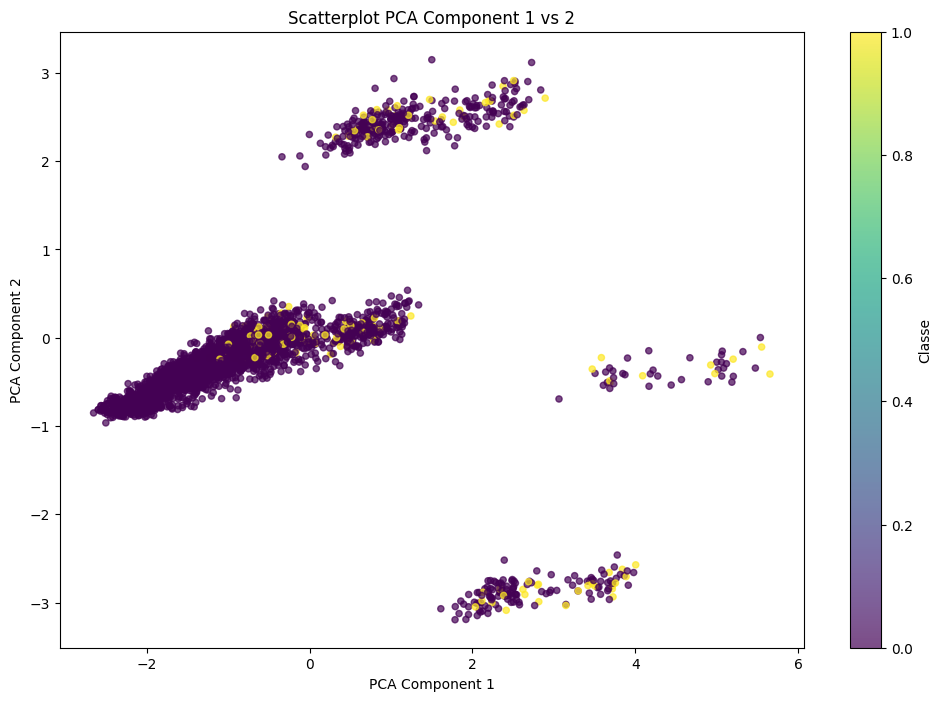

In [9]:
explorationByPCA(X_train, y_train, pipeline, 2)

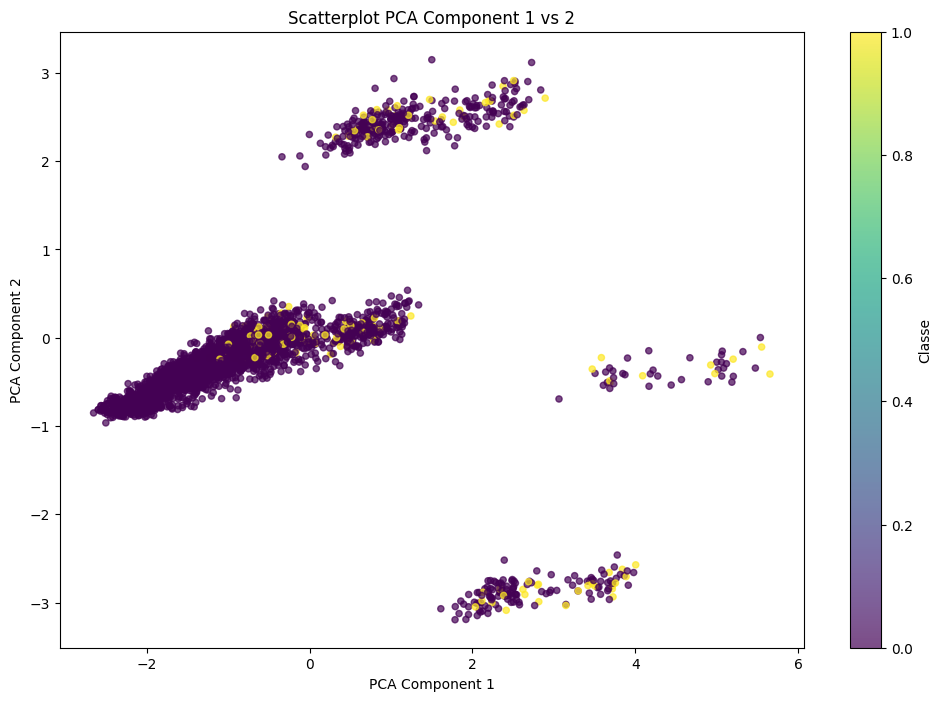

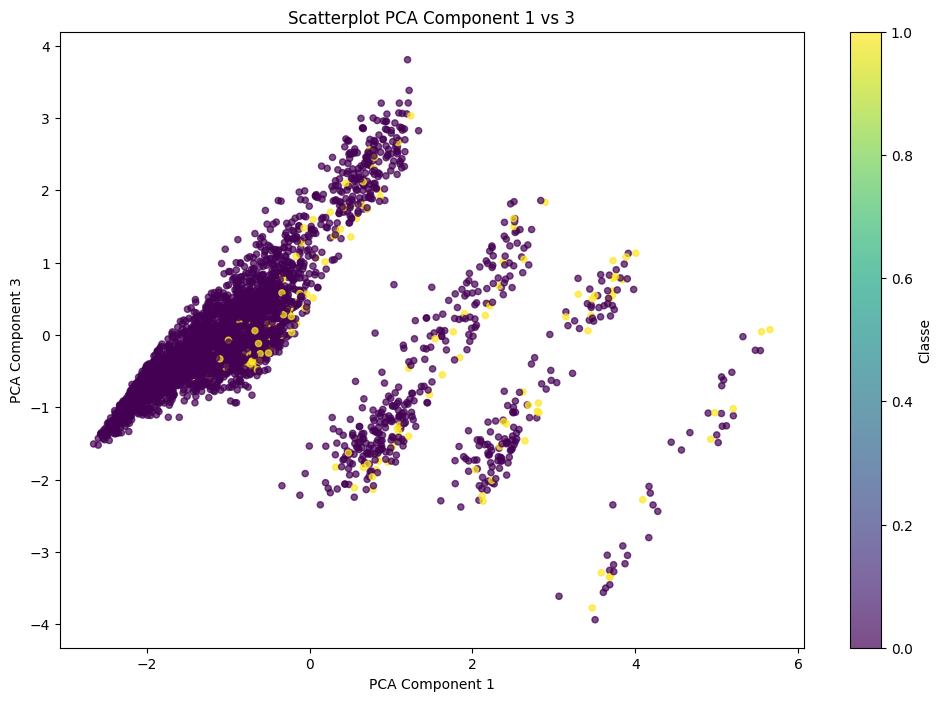

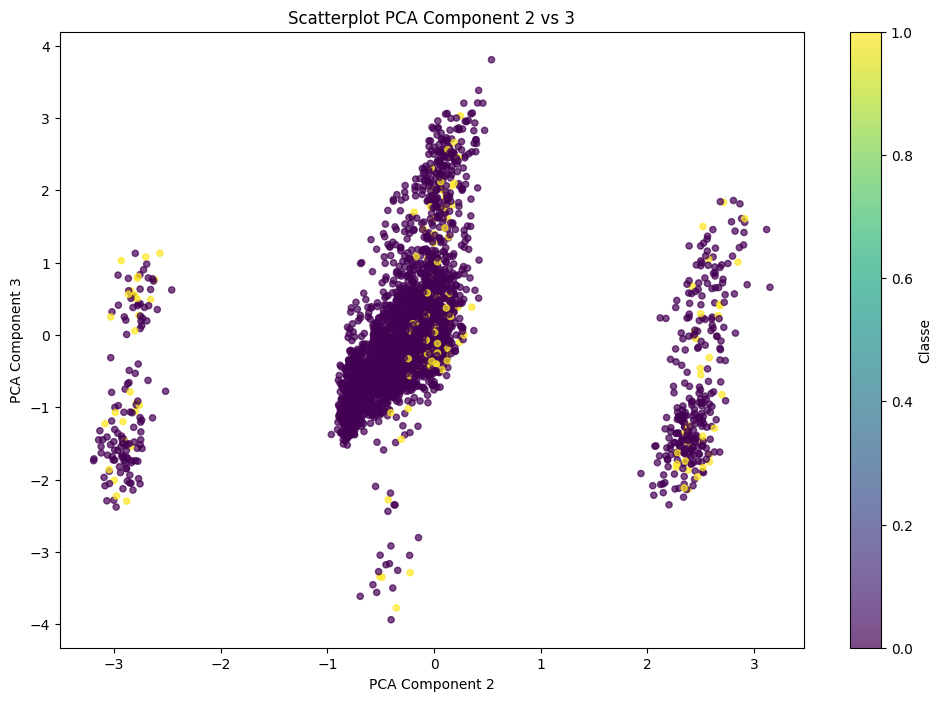

In [10]:
explorationByPCA(X_train, y_train, pipeline, 3)

In [11]:
# questi esempi sono stati comunque testati ma li ho commentati in quanto occupavano molto spazio e non tornavano alcun risultato utile
# explorationByPCA(X_train, y_train, pipeline, 4)
# explorationByPCA(X_train, y_train, pipeline, 5)
# explorationByPCA(X_train, y_train, pipeline, 6)
# explorationByPCA(X_train, y_train, pipeline, 7)
# explorationByPCA(X_train, y_train, pipeline, 8)
# explorationByPCA(X_train, y_train, pipeline, 9)
# explorationByPCA(X_train, y_train, pipeline, 10)

Non sembra esistere un modo per separare le classi basandosi su visualizzazione in 2 dimensioni.

Potrei provare a fare pca a più dimensioni e vedere se riesco a trovare un algoritmo che cerca di separarli automaticamente

In [ ]:
# res = []


# def calculate_rf_performance(X_subset, y, beta=2):
#     scorer = make_scorer(fbeta_score, beta=beta, pos_label=1)
#     model = RandomForestClassifier(
#         n_estimators=100,
#         max_depth=7,
#         class_weight='balanced',
#         random_state=0,
#         n_jobs=-1
#     )
#     return cross_val_score(model, X_subset, y, cv=5, scoring=scorer).mean()

def calculate_svm_performance(X_subset, y, beta=2):
    scorer = make_scorer(fbeta_score, beta=beta, pos_label=1)
    model = SVC(kernel='rbf', class_weight='balanced', C=1.0, probability=True, random_state=0)
    # classifier = SVC(kernel='rbf', random_state=0, class_weight='balanced')
    return cross_val_score(model, X_subset, y, cv=5, scoring=scorer).mean()

def findDataByPCA(X, y, pipeline, n_components, n_dims_to_combine=2):
    if not 'pca' in pipeline.named_steps:
        raise ValueError("La pipeline deve contenere uno step chiamato 'pca'.")
    if n_dims_to_combine > n_components:
        raise ValueError("n_dims_to_combine non può essere maggiore di n_components.")
    if n_dims_to_combine <= 0:
        raise ValueError("n_dims_to_combine deve essere un numero positivo.")

    pipeline.named_steps['pca'].n_components = n_components
    X_pca_full = pipeline.transform(X)

    best_metric_value = -np.inf
    best_components_indices = None
    best_X_pca_projection = None

    all_combinations = list(combinations(range(n_components), n_dims_to_combine))
    
    for combo_indices in all_combinations:
        X_pca_subset = X_pca_full[:, list(combo_indices)]

        current_metric = calculate_svm_performance(X_pca_subset, y, beta=2)

        if current_metric > best_metric_value:
            best_metric_value = current_metric
            best_components_indices = combo_indices
            best_X_pca_projection = X_pca_subset
        # res.append({'n_principal_components': n_components, 'best_metric_value': current_metric, 'best_component_indices': combo_indices})
    return best_metric_value, best_components_indices, best_X_pca_projection

In [13]:
n_components = 9
start = 2
n_subsets = n_components - start

X_subsets = np.array_split(X_train, n_subsets)
y_subsets = np.array_split(y_train, n_subsets)


C:\Users\David\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [14]:
len(X_subsets)

7

In [15]:
res = []

# for i in range(3, n_components - 1):
for j in range(start, n_components):
  print(j)
  best_metric_value, best_component_indices, best_x_pca_projection = findDataByPCA(X_subsets[j-start], y_subsets[j-start], pipeline, n_components, j)
  res.append({'n_principal_components': n_components, 'best_metric_value': best_metric_value, 'best_component_indices': best_component_indices})

2
3
4
5
6
7
8


In [16]:
res

[{'n_principal_components': 9,
  'best_metric_value': np.float64(0.43797373758940966),
  'best_component_indices': (0, 3)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.3806264663260099),
  'best_component_indices': (1, 4, 5)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.3574137549756745),
  'best_component_indices': (0, 2, 6, 8)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.43057274793517675),
  'best_component_indices': (0, 3, 4, 7, 8)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.46870225311403163),
  'best_component_indices': (0, 1, 2, 3, 4, 5)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.3128196862239415),
  'best_component_indices': (0, 1, 2, 3, 4, 5, 7)},
 {'n_principal_components': 9,
  'best_metric_value': np.float64(0.49676888299179317),
  'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7)}]

In [17]:
type(res)

list

In [18]:
res_unique = [dict(t) for t in {tuple(sorted(d.items())) for d in res}]

In [19]:
sorted_data = sorted(res_unique, key=lambda x: x['best_metric_value'], reverse=True)
sorted_data

[{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7),
  'best_metric_value': np.float64(0.49676888299179317),
  'n_principal_components': 9},
 {'best_component_indices': (0, 1, 2, 3, 4, 5),
  'best_metric_value': np.float64(0.46870225311403163),
  'n_principal_components': 9},
 {'best_component_indices': (0, 3),
  'best_metric_value': np.float64(0.43797373758940966),
  'n_principal_components': 9},
 {'best_component_indices': (0, 3, 4, 7, 8),
  'best_metric_value': np.float64(0.43057274793517675),
  'n_principal_components': 9},
 {'best_component_indices': (1, 4, 5),
  'best_metric_value': np.float64(0.3806264663260099),
  'n_principal_components': 9},
 {'best_component_indices': (0, 2, 6, 8),
  'best_metric_value': np.float64(0.3574137549756745),
  'n_principal_components': 9},
 {'best_component_indices': (0, 1, 2, 3, 4, 5, 7),
  'best_metric_value': np.float64(0.3128196862239415),
  'n_principal_components': 9}]

In [20]:
most_indicative_data = sorted_data[0]

In [21]:
most_indicative_data

{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7),
 'best_metric_value': np.float64(0.49676888299179317),
 'n_principal_components': 9}

In [ ]:
def evaluate_pca_with_classifier(X, y, pipeline, n_components, dimension_list):
    pipeline.named_steps['pca'].n_components = n_components
    X_pca = pipeline.transform(X)

    X_selected = X_pca[:, dimension_list]

    classifier = SVC(kernel='rbf', random_state=0, C=1.0, probability=True, class_weight='balanced') # Puoi provare anche 'linear' o RandomForestClassifier

    y_pred = cross_val_predict(classifier, X_selected, np.array(y), cv=5)
    return y_pred

In [23]:
sorted_data

[{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7),
  'best_metric_value': np.float64(0.49676888299179317),
  'n_principal_components': 9},
 {'best_component_indices': (0, 1, 2, 3, 4, 5),
  'best_metric_value': np.float64(0.46870225311403163),
  'n_principal_components': 9},
 {'best_component_indices': (0, 3),
  'best_metric_value': np.float64(0.43797373758940966),
  'n_principal_components': 9},
 {'best_component_indices': (0, 3, 4, 7, 8),
  'best_metric_value': np.float64(0.43057274793517675),
  'n_principal_components': 9},
 {'best_component_indices': (1, 4, 5),
  'best_metric_value': np.float64(0.3806264663260099),
  'n_principal_components': 9},
 {'best_component_indices': (0, 2, 6, 8),
  'best_metric_value': np.float64(0.3574137549756745),
  'n_principal_components': 9},
 {'best_component_indices': (0, 1, 2, 3, 4, 5, 7),
  'best_metric_value': np.float64(0.3128196862239415),
  'n_principal_components': 9}]

In [24]:
len(sorted_data)

7

In [25]:
predictions_train = []
predictions_test = []

for cur_data in sorted_data:
  # print(i)
  # cur_data = sorted_data[i]
  print(most_indicative_data)
  print('valutazione dati di train')
  predictions_train.append(evaluate_pca_with_classifier(X_train, y_train, pipeline, n_components=cur_data['n_principal_components'], dimension_list=cur_data['best_component_indices']))
  print('valutazione dati di test')
  predictions_test.append(evaluate_pca_with_classifier(X_test, y_test, pipeline, cur_data['n_principal_components'], dimension_list=cur_data['best_component_indices']))



{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric_value': np.float64(0.49676888299179317), 'n_principal_components': 9}
valutazione dati di train
valutazione dati di test
{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric_value': np.float64(0.49676888299179317), 'n_principal_components': 9}
valutazione dati di train
valutazione dati di test
{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric_value': np.float64(0.49676888299179317), 'n_principal_components': 9}
valutazione dati di train
valutazione dati di test
{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric_value': np.float64(0.49676888299179317), 'n_principal_components': 9}
valutazione dati di train
valutazione dati di test
{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric_value': np.float64(0.49676888299179317), 'n_principal_components': 9}
valutazione dati di train
valutazione dati di test
{'best_component_indices': (0, 1, 2, 3, 4, 5, 6, 7), 'best_metric

In [26]:
predictions_train

[array([0, 1, 0, ..., 0, 0, 1], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 1], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 1], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 0], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 1], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 1], shape=(3577,)),
 array([0, 1, 0, ..., 0, 0, 1], shape=(3577,))]

In [39]:
def evaluate_predictions(predictions, y_true):
    majority_vote = (np.stack(predictions).mean(axis=0) >= 0.2).astype(int)
    cm = confusion_matrix(y_true, majority_vote)
    class_names = ['Classe 0 (Nessun ictus)', 'Classe 1 (Ictus)']
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(values_format='d')
    plt.show()
    
    perc_true_negative = cm[0,0]*100/(cm[0,0]+cm[0,1])
    perc_true_positive = cm[1,1]*100/(cm[1,0]+cm[1,1])
    
    print(f"Percentuale di veri negativi: {perc_true_negative:.2f}%")
    print(f"Percentuale di veri positivi: {perc_true_positive:.2f}%")
    
    print(classification_report(y_true, majority_vote, target_names=class_names))
    print(cm)
    
    fpr, tpr, thresholds = roc_curve(y_true, majority_vote)
    auc = roc_auc_score(y_true, majority_vote)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {auc:.4f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - SVM')
    plt.legend(loc='lower right')
    plt.show()

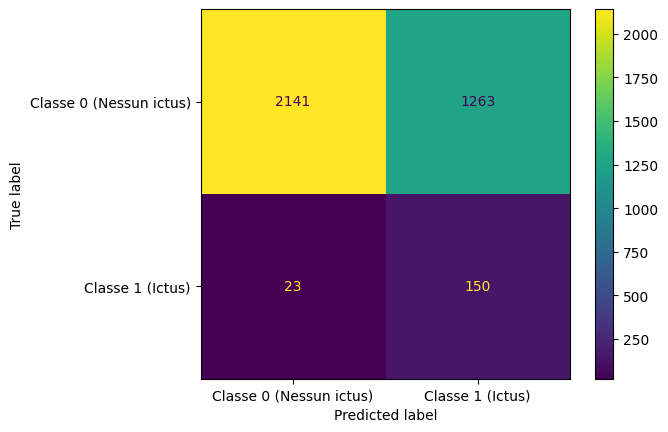

Percentuale di veri negativi: 62.90%
Percentuale di veri positivi: 86.71%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.63      0.77      3404
       Classe 1 (Ictus)       0.11      0.87      0.19       173

               accuracy                           0.64      3577
              macro avg       0.55      0.75      0.48      3577
           weighted avg       0.95      0.64      0.74      3577

[[2141 1263]
 [  23  150]]


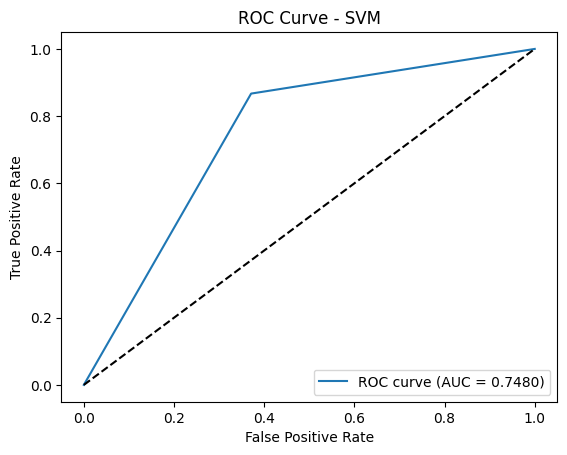

In [40]:
evaluate_predictions(predictions_train, y_train)

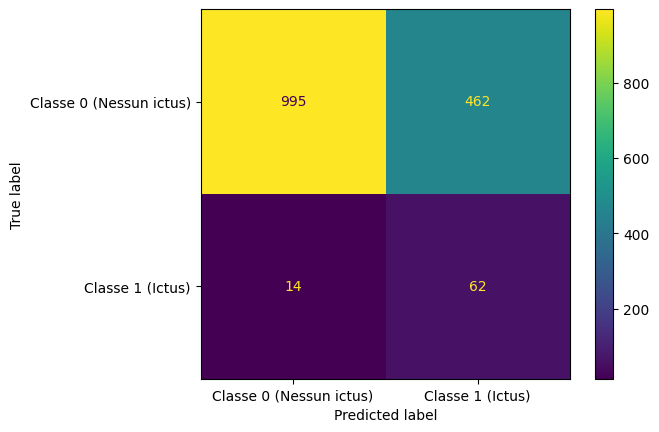

Percentuale di veri negativi: 68.29%
Percentuale di veri positivi: 81.58%
                         precision    recall  f1-score   support

Classe 0 (Nessun ictus)       0.99      0.68      0.81      1457
       Classe 1 (Ictus)       0.12      0.82      0.21        76

               accuracy                           0.69      1533
              macro avg       0.55      0.75      0.51      1533
           weighted avg       0.94      0.69      0.78      1533

[[995 462]
 [ 14  62]]


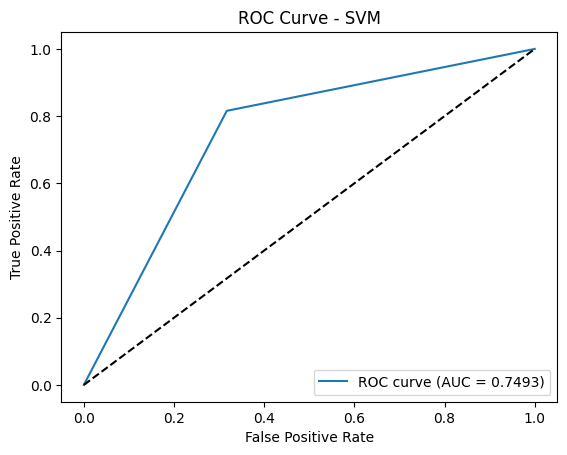

In [41]:
evaluate_predictions(predictions_test, y_test)